In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import harmony as harm
from astropy.io import fits
from tqdm import tqdm
import camb

import glass.shells
import glass.lensing

from mass_maping import kaiser_squire

In [2]:
num_sim = 2
rot_i = 0
rot_j = 0
noise_real = 0
path_output = f'/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim{num_sim:05d}_nside0512_rot{rot_i}{rot_j}_noisereal{noise_real}.npy'
output = np.load(path_output, allow_pickle=True).item()

This notebook is meant to check that the output of the UNIONS forward model pipeline is correct.

In [3]:
output.keys()

dict_keys(['cosmo_params', 'config', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5', 'nuisance_parameters'])

In [4]:
#Check the config
output['config']

{'simulation': {'path_simulation': '/n17data/sguerrini/GowerStreetSims/',
  'path_info': '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv',
  'path_output': '/n17data/sguerrini/GowerStreetSims/processed/',
  'sim_number': 2,
  'sim_name': 'GowerStreet'},
 'preprocessing': {'nside': 512},
 'ray_tracing': {'method': 'glass', 'save_ray_tracing': 'F'},
 'intrinsic_alignment': {'add_ia': 'T',
  'prior_A_ia': [-3.0, 3.0],
  'prior_eta_ia': [-5.0, 5.0]},
 'redshift_distribution': {'weight_w_redshift': 'T',
  'nbins': 5,
  'path_dndz': '/home/guerrini/UNIONS_forward_model/data_utils/dndz.txt',
  'save': 'F',
  'save_cl': 'T',
  'm_bias': '/home/guerrini/UNIONS_forward_model/data_utils/m_bias_prior.txt'},
 'shape_noise': {'add_shape_noise': 'T',
  'path_gal': '/n17data/mkilbing/astro/data/CFIS/v1.0/SP_LFmask/unions_shapepipe_2022_v1.3_mtheli8k.fits',
  'ra_col': 'RA',
  'dec_col': 'Dec',
  'e1_col': 'e1',
  'e2_col': 'e2',
  'w_col': 'w',
  'save': 'T'},
 'psf_systemat

In [5]:
#Check cosmo_params and nuisance params
print(output['cosmo_params'])
print(output['nuisance_parameters'])

{'h': array([0.71654738]), 'Omega_m': array([0.24962876]), 'Omega_b': array([0.04350883]), 'sigma_8': array([0.95049616]), 'n_s': array([0.95131107]), 'w': array([-0.7924174]), 'm_nu': array([0.06]), 'A_s': array([3.96819025e-09])}
{'A_ia': 2.8350137015831995, 'eta_ia': 2.4352737952478005, 'bin_1': {'m_bias': -0.02031793101924846, 'alpha': 0.009382419424267678, 'beta': 1.18164870003811, 'eta': -1.7615776264432155}, 'bin_2': {'m_bias': -0.029318466044935074, 'alpha': 0.012957618989911423, 'beta': 1.1180892182828115, 'eta': -0.5569089949313177}, 'bin_3': {'m_bias': -0.021935741370658075, 'alpha': 0.011951900073528286, 'beta': 1.0503465338232267, 'eta': -0.577002214408676}, 'bin_4': {'m_bias': -0.03870079931412666, 'alpha': 0.010992867740167604, 'beta': 0.985994853008419, 'eta': -0.582962591232201}, 'bin_5': {'m_bias': -0.045308021099401616, 'alpha': 0.009513285512117158, 'beta': 1.0008866214539305, 'eta': -2.4157796651841954}}


In [6]:
print(output['bin_1'].keys())

dict_keys(['cl_FS_gamma', 'masked_shear_map', 'noise_map', 'idx', 'sys_map', 'idx_star'])


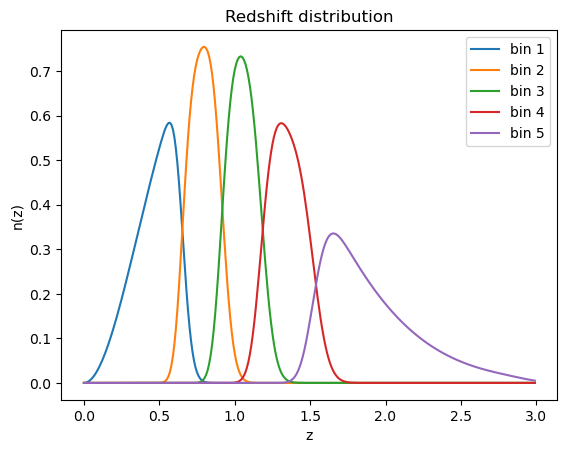

In [7]:
redshift_distr = np.loadtxt(output['config']['redshift_distribution']['path_dndz'])
z = redshift_distr[:, 0]

plt.figure()

for i in range(output['config']['redshift_distribution']['nbins']):
    plt.plot(z, redshift_distr[:, i+1], label=f'bin {i+1}')
plt.legend()
plt.title('Redshift distribution')
plt.xlabel('z')
plt.ylabel('n(z)')

plt.show()

In [27]:
output

{'cosmo_params': {'h': array([0.71654738]),
  'Omega_m': array([0.24962876]),
  'Omega_b': array([0.04350883]),
  'sigma_8': array([0.95049616]),
  'n_s': array([0.95131107]),
  'w': array([-0.7924174]),
  'm_nu': array([0.06]),
  'A_s': array([3.96819025e-09])},
 'config': {'simulation': {'path_simulation': '/n17data/sguerrini/GowerStreetSims/',
   'path_info': '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv',
   'path_output': '/n17data/sguerrini/GowerStreetSims/processed/',
   'sim_number': 2,
   'sim_name': 'GowerStreet'},
  'preprocessing': {'nside': 512},
  'ray_tracing': {'method': 'glass', 'save_ray_tracing': 'F'},
  'intrinsic_alignment': {'add_ia': 'T',
   'prior_A_ia': [-3.0, 3.0],
   'prior_eta_ia': [-5.0, 5.0]},
  'redshift_distribution': {'weight_w_redshift': 'T',
   'nbins': 5,
   'path_dndz': '/home/guerrini/UNIONS_forward_model/data_utils/dndz.txt',
   'save': 'F',
   'save_cl': 'T',
   'm_bias': '/home/guerrini/UNIONS_forward_model/data_util

In [8]:
#Checking the power spectrum of the convergence and shear fields
#Load parameters for the cosmology
h = output['cosmo_params']["h"]
Om = output['cosmo_params']["Omega_m"]
Ob = output['cosmo_params']["Omega_b"]
Oc = Om - Ob
ns = output['cosmo_params']["n_s"]
m_nu = output['cosmo_params']["m_nu"]
w = output['cosmo_params']["w"]
As = output['cosmo_params']["A_s"]

nside=512
lmax = 2*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
Onu = pars.omeganu
Oc = Om - Ob - Onu
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#get the angular power spectra of the lensing map
sim_cls = output['bin_4']['cl_FS_gamma']

z, dndz = redshift_distr[:, 0], redshift_distr[:, 4]

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

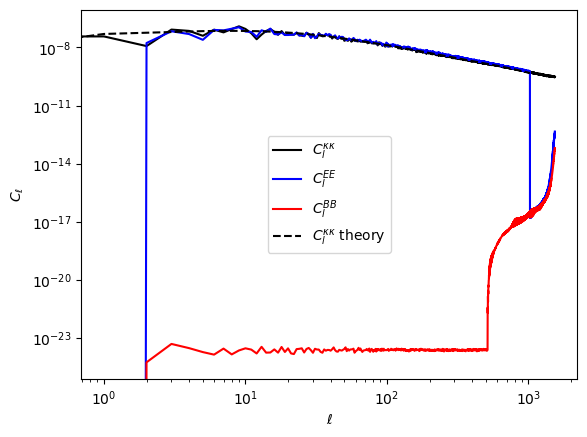

In [9]:
pw = hp.pixwin(nside, lmax=lmax)

plt.figure()

lmax = 3*nside
l = np.arange(lmax+1)
plt.plot(l, sim_cls[0], label='$C_l^{\kappa\kappa}$', c='k')
plt.plot(l, sim_cls[1], label='$C_l^{EE}$', c='b')
plt.plot(l, sim_cls[2], label='$C_l^{BB}$', c='r')
lmax = 2*nside
l = np.arange(lmax+1)
plt.plot(l, theory_cls['W1xW1']*pw**2, label='$C_l^{\kappa\kappa}$ theory', c='k', ls='--')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

In [10]:
nside = output['config']['preprocessing']['nside']

noise_map = np.zeros(hp.nside2npix(nside), dtype=np.complex128)
idx_gal = output['bin_4']['idx']
noise_map[idx_gal] += output['bin_4']['noise_map']

/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


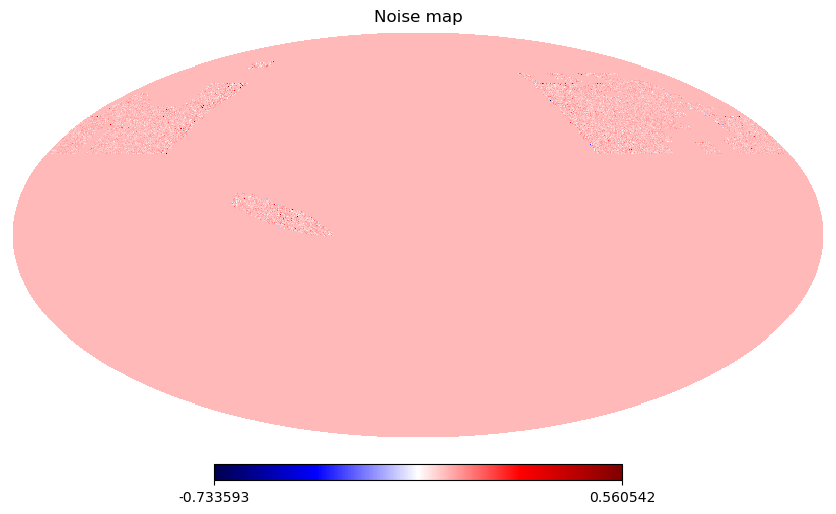

In [11]:
#Look at the noise map + mask
hp.mollview(noise_map, title='Noise map', cmap='seismic')
plt.show()

In [12]:
#Measure the pseudo-Cl's of the noise map (should correspond to the noise bias in Doux et al.)
lmin = 8
lmax = 3*nside-1
b_lmax = 3*nside-1
n_ell_bins = 28

b = nmt.NmtBin.from_nside_linear(nside, 10)

ell_eff = b.get_effective_ells()

f_noise = nmt.NmtField(mask=(noise_map != 0), maps=[noise_map.real, noise_map.imag])

cl_noise = nmt.compute_full_master(f_noise, f_noise, b)

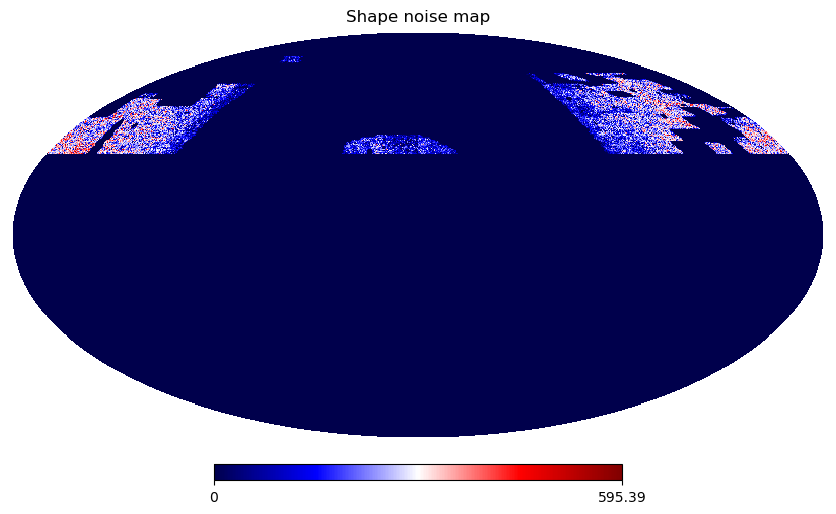

Noise bias: 5.7333702825872006e-05


In [13]:
#Compute the noise bias following Nicola et al.
cat_gal = fits.getdata(output['config']['shape_noise']['path_gal'])

ra_col = output['config']['shape_noise']['ra_col']
dec_col = output['config']['shape_noise']['dec_col']
w_col = output['config']['shape_noise']['w_col']
e1_col = output['config']['shape_noise']['e1_col']
e2_col = output['config']['shape_noise']['e2_col']

theta = (90 - cat_gal[dec_col]) * np.pi / 180
phi = cat_gal[ra_col] * np.pi / 180
pix = hp.ang2pix(nside, theta, phi)

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)

shape_noise_map = np.zeros(hp.nside2npix(nside))
weights_shape_noise_map = 0.5*cat_gal[w_col]**2*(cat_gal[e1_col]**2 + cat_gal[e2_col]**2)
shape_noise_map[unique_pix] += np.bincount(idx_rep, weights=weights_shape_noise_map)

hp.mollview(shape_noise_map, title='Shape noise map', cmap='seismic')
plt.show()

area_pix = hp.nside2pixarea(nside)
noise_bias = area_pix*np.mean(shape_noise_map)
print(f'Noise bias: {noise_bias}') #Ew doesn't look good

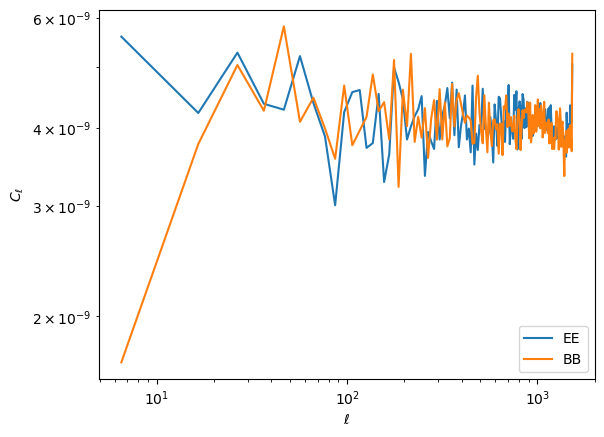

In [14]:
plt.figure()

plt.plot(ell_eff, cl_noise[0], label='EE')
plt.plot(ell_eff, cl_noise[3], label='BB')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

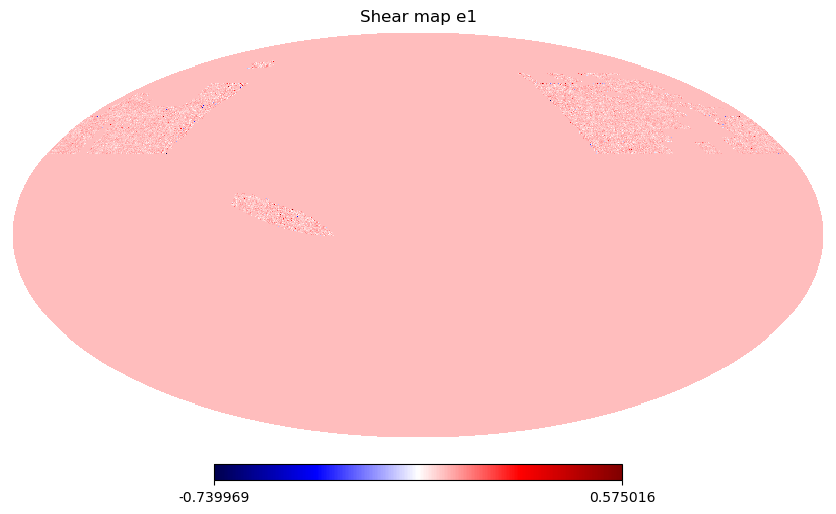

In [15]:
#Check maps with noise and shear signal
shear_map = np.zeros(hp.nside2npix(nside), dtype=np.complex128)
shear_map[idx_gal] += output['bin_4']['masked_shear_map'] + output['bin_4']['noise_map']

hp.mollview(shear_map.real, title='Shear map e1', cmap='seismic')
plt.show()

In [16]:
kappa_E, kappa_B = kaiser_squire(shear_map)

/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: invalid value encountered in multiply
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: invalid value encountered in multiply


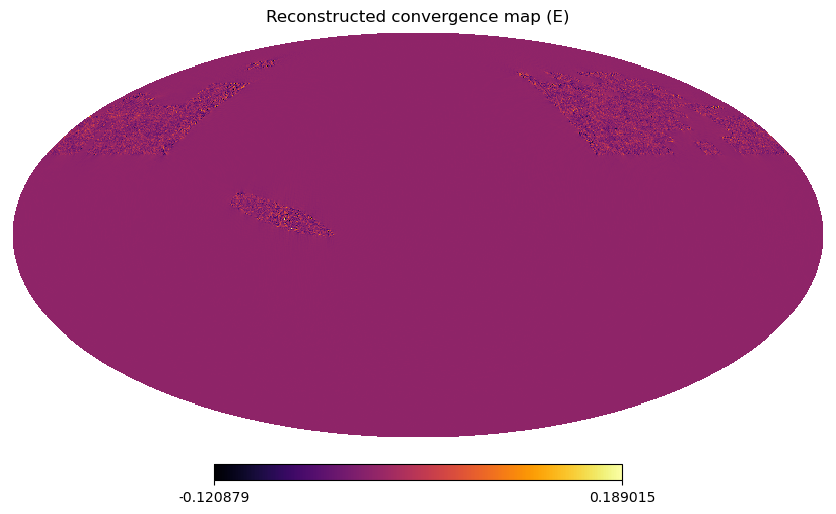

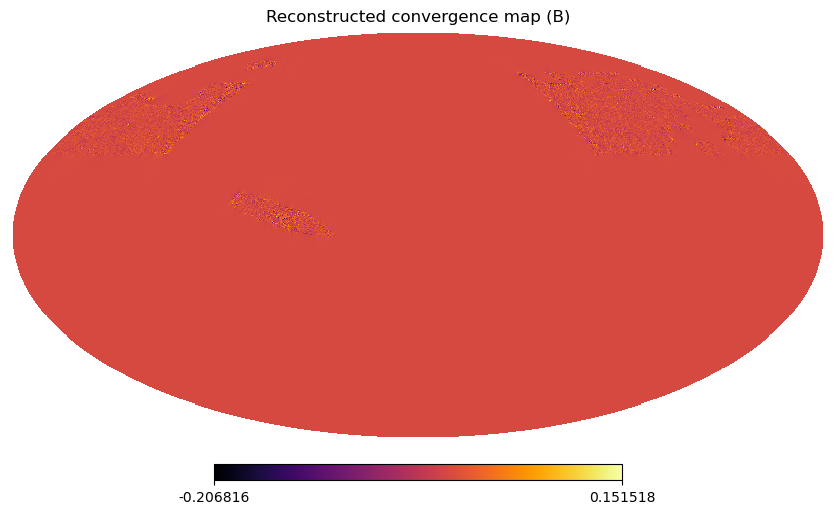

In [17]:
hp.mollview(kappa_E, title='Reconstructed convergence map (E)', cmap='inferno')
plt.show()

hp.mollview(kappa_B, title='Reconstructed convergence map (B)', cmap='inferno')
plt.show()

In [18]:
#Let's check that we got some signal in the pseudo-Cl's

lmin = 8
lmax = 3*nside-1
b_lmax = 3*nside-1
n_ell_bins = 28

b = nmt.NmtBin.from_nside_linear(nside, 10)

ell_eff = b.get_effective_ells()

f_all = nmt.NmtField(mask=(shear_map != 0), maps=[shear_map.real, shear_map.imag])

cl_all = nmt.compute_full_master(f_all, f_all, b)

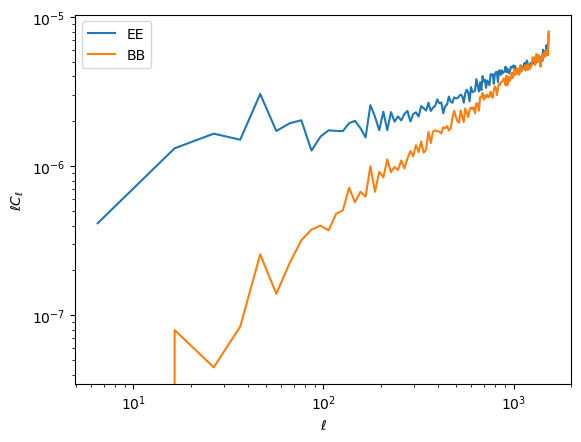

In [19]:
plt.figure()

plt.plot(ell_eff, ell_eff*cl_all[0], label='EE')
plt.plot(ell_eff, ell_eff*cl_all[3], label='BB')

plt.xlabel('$\ell$')
plt.ylabel('$\ell C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

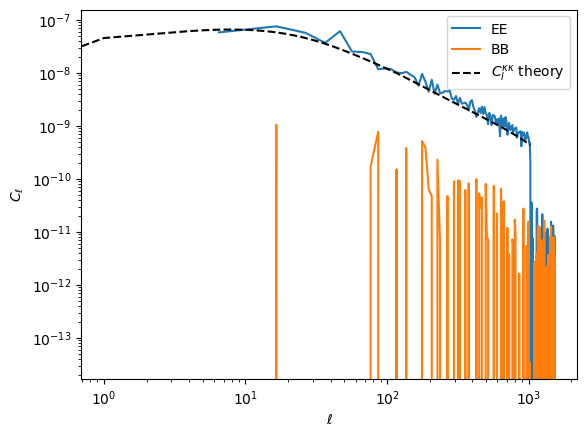

In [20]:
m_bias = output['nuisance_parameters']['bin_4']['m_bias']

plt.figure()

plt.plot(ell_eff, cl_all[0]-cl_noise[0], label='EE')
plt.plot(ell_eff, cl_all[3]-cl_noise[3], label='BB')
plt.plot(l, theory_cls['W1xW1']*pw**2*(1+m_bias)**2, label='$C_l^{\kappa\kappa}$ theory', c='k', ls='--')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

### Check convergence power spectrum on all simulations

In [22]:
num_sim = 2

cls_ = {
    'bin_1': [],
    'bin_2': [],
    'bin_3': [],
    'bin_4': [],
    'bin_5': []
}
for noise_real in range(2):
    for rot_i in range(5):
        for rot_j in range(5):
            path_output = f'/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim{num_sim:05d}_nside0512_rot{rot_i}{rot_j}_noisereal{noise_real}.npy'
            if os.path.exists(path_output):
                output = np.load(path_output, allow_pickle=True).item()
                for key in cls_.keys():
                    cls_[key].append(output[key]['cl_FS_gamma'])

In [25]:
#Get theoretical predictions
cls_theory = {}

redshift_distr = np.loadtxt(output['config']['redshift_distribution']['path_dndz'])

for i, key in tqdm(enumerate(cls_.keys())):
    #Checking the power spectrum of the convergence and shear fields
    #Load parameters for the cosmology
    h = output['cosmo_params']["h"]
    Om = output['cosmo_params']["Omega_m"]
    Ob = output['cosmo_params']["Omega_b"]
    Oc = Om - Ob
    ns = output['cosmo_params']["n_s"]
    m_nu = output['cosmo_params']["m_nu"]
    w = output['cosmo_params']["w"]
    As = output['cosmo_params']["A_s"]

    nside=output['config']['preprocessing']['nside']
    lmax = 3*nside

    pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
    Onu = pars.omeganu
    Oc = Om - Ob - Onu
    pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

    #get the angular power spectra of the lensing map
    sim_cls = output[key]['cl_FS_gamma']

    z, dndz = redshift_distr[:, 0], redshift_distr[:, i+1]

    #getthe expected cl's from CAMB
    pars.min_l = 1
    pars.set_for_lmax(lmax)
    pars.SourceWindows = [
        camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
    ]
    theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)
    cls_theory[key] = theory_cls

5it [00:54, 10.90s/it]


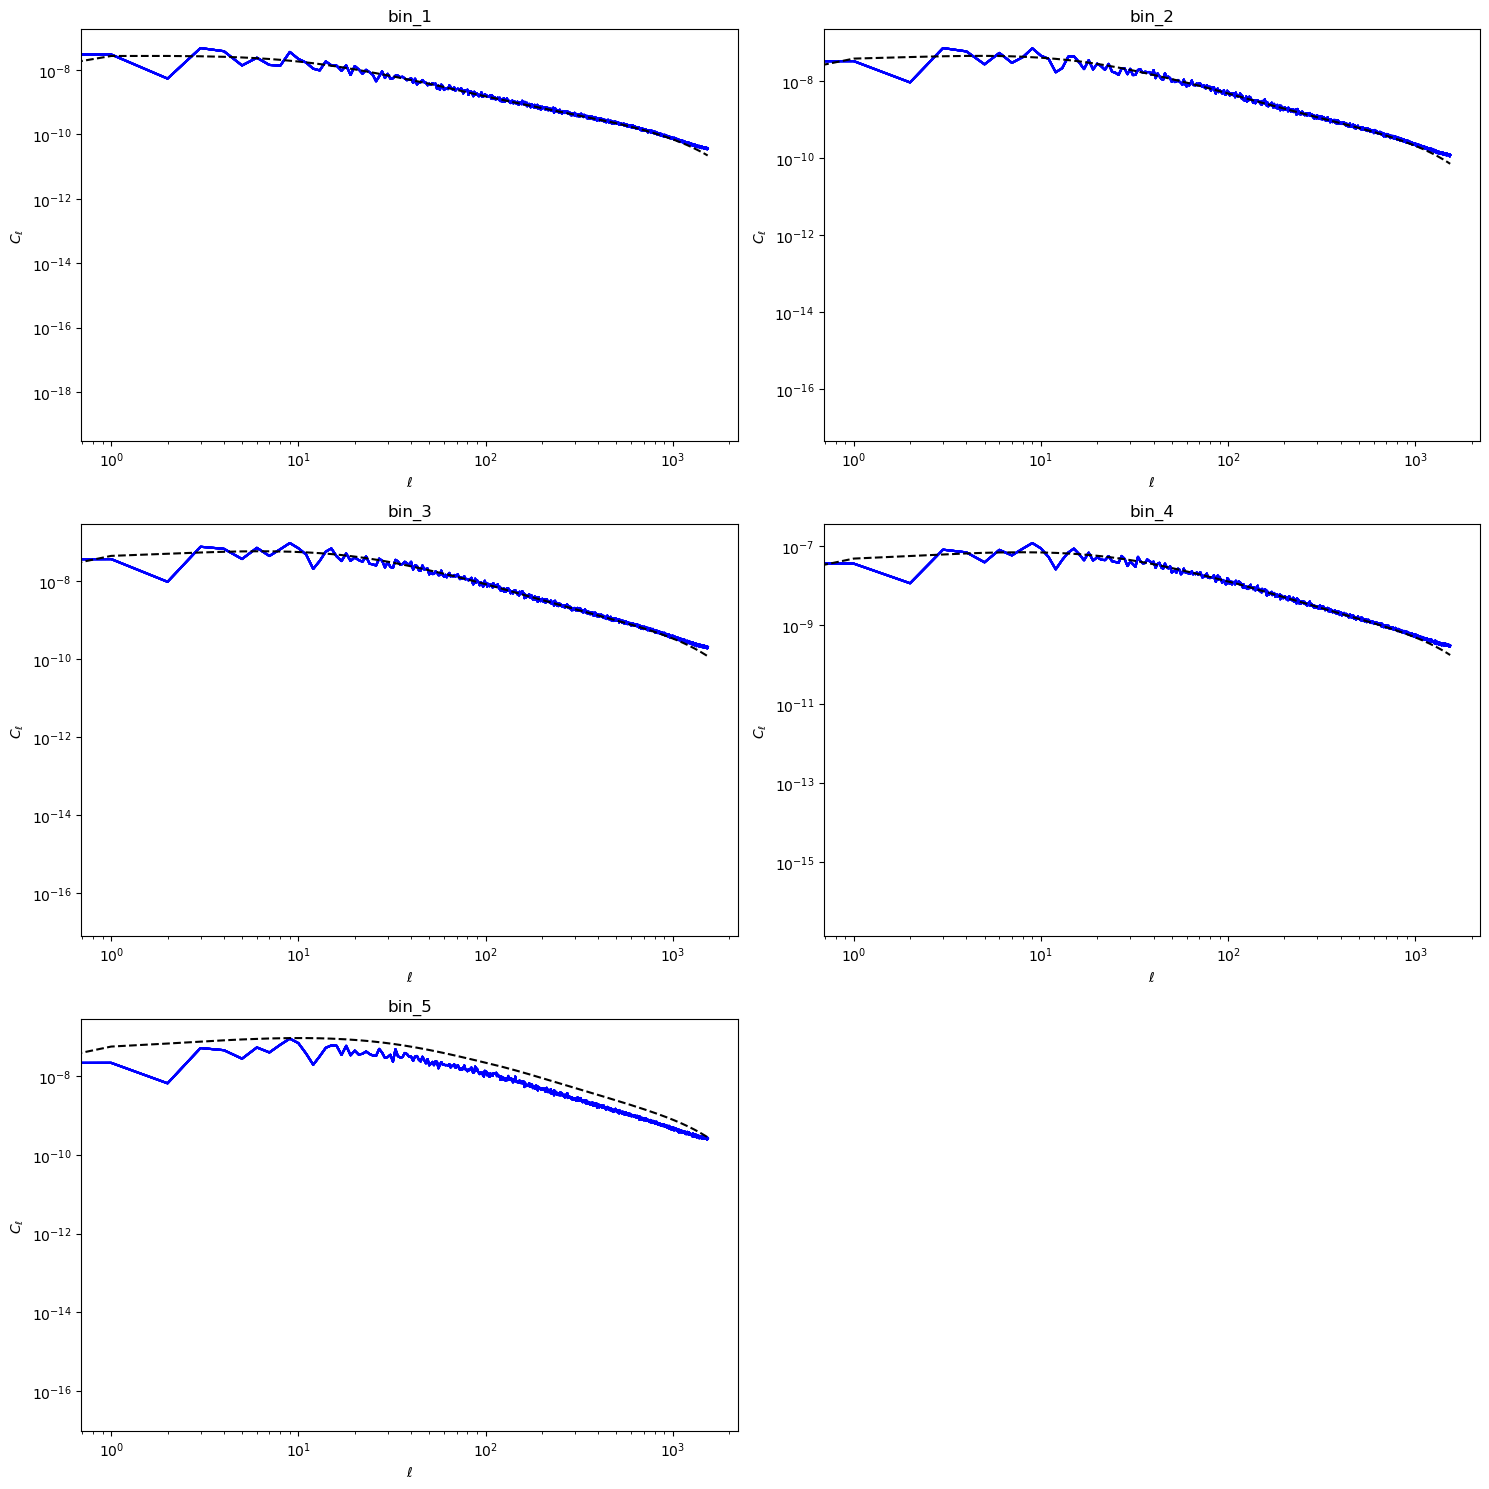

In [26]:
#The 5th redshift bin can safely be ignored as the simulations do not cover the highest redshifts in which the distribution is non-zero

plt.figure(figsize = (15, 15))

for i, key in enumerate(cls_.keys()):
    plt.subplot(3, 2, i+1)
    lmax = 3*nside
    pw = hp.pixwin(nside, lmax=lmax)
    l = np.arange(lmax+1)
    for cls in cls_[key]:
        plt.plot(l, cls[0], c='b', alpha=0.5)
    plt.plot(l, cls_theory[key]['W1xW1']*pw**2, label='$C_l^{\kappa\kappa}$ theory', c='k', ls='--')

    plt.xlabel('$\ell$')
    plt.ylabel('$C_\ell$')
    plt.title(f'{key}')

    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()